In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import io
import pandas as pd
from pyspark.sql import SparkSession
from google.colab import drive
drive.mount('/content/drive')
#!ls '/content/drive/My Drive/Project4-Loan_Analysis'
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

Mounted at /content/drive


**Loading and Preprocessing Loans Encoded Data**

In [ ]:
# Install necessary packages
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz
!pip install -q findspark
!pip install gcsfs

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

# Import findspark and initialize
import findspark
findspark.init()

# Now create the Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("GoogleDriveCSV") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem")\
    .config("fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS")\
    .getOrCreate()


# Define the file path on Google Drive
file_path_csv = 'gs://MyDrive/Colab_Notebooks/Project4-Loan_Analysis/full_loan_data.csv' # Update with your file path


# Load the CSV file into a Spark DataFrame
df = spark.read.csv(file_path_csv, header=True, inferSchema=True)

# Convert and save to Parquet
#file_path_parquet = '/content/drive/MyDrive/Colab_Notebooks/Project4-Loan_Analysis/full_loan_data.parquet'
#df.write.parquet(file_path_parquet, mode="overwrite")
#df_parquet = spark.read.parquet(file_path_parquet)

# Convert the Spark DataFrame to Pandas
df_loans = df.toPandas()

# Show the dataframe
df_loans.head()


ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
# desribe the dataset
df_loans.describe()

,pct_tl_nvr_dlq,delinq_amnt,annual_inc,loan_amnt,emp_length,avg_cur_bal,pub_rec_bankruptcies,acc_now_delinq,int_rate,open_acc,...,dti,mths_since_last_delinq,total_bal_ex_mort,total_acc,total_bc_limit,chargeoff_within_12_mths,num_tl_90g_dpd_24m,delinq_2yrs,all_util,term_months
count,495240.000000,495242.000000,4.952420e+05,495242.000000,453255.000000,495202.000000,495242.000000,495242.000000,495242.000000,495242.000000,...,494110.000000,218590.000000,4.952420e+05,495242.000000,4.952420e+05,495242.000000,495242.000000,495242.000000,495113.000000,495242.000000
mean,94.580900,1.792829,8.009399e+04,16025.020394,5.892303,13709.348688,0.123489,0.000052,12.729272,11.491554,...,19.668887,36.889771,5.192192e+04,22.624151,2.667946e+04,0.006823,0.059932,0.229252,54.087778,43.296845
std,9.092862,211.140366,8.887161e+04,10138.075023,3.612149,17229.551500,0.335296,0.007245,5.150130,5.947129,...,20.458244,21.777614,5.339667e+04,12.104004,2.582489e+04,0.093093,0.420412,0.743665,21.027364,11.039954
min,0.000000,0.000000,0.000000e+00,1000.000000,1.000000,0.000000,0.000000,0.000000,5.310000,0.000000,...,0.000000,0.000000,0.000000e+00,2.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,36.000000
25%,92.300000,0.000000,4.600000e+04,8000.000000,2.000000,2904.000000,0.000000,0.000000,8.460000,7.000000,...,11.430000,19.000000,1.953000e+04,14.000000,9.800000e+03,0.000000,0.000000,0.000000,40.000000,36.000000
50%,100.000000,0.000000,6.600000e+04,14000.000000,6.000000,7033.000000,0.000000,0.000000,11.800000,10.000000,...,17.710000,34.000000,3.755600e+04,21.000000,1.920000e+04,0.000000,0.000000,0.000000,55.000000,36.000000
75%,100.000000,0.000000,9.600000e+04,22000.000000,10.000000,19031.000000,0.000000,0.000000,16.010000,14.000000,...,25.030000,53.000000,6.611900e+04,29.000000,3.520000e+04,0.000000,0.000000,0.000000,69.000000,60.000000
max,100.000000,65000.000000,9.930475e+06,40000.000000,10.000000,623229.000000,7.000000,1.000000,30.990000,101.000000,...,999.000000,226.000000,2.622906e+06,160.000000,1.569000e+06,9.000000,58.000000,58.000000,239.000000,60.000000


In [ ]:
# Define the feature set
X = df_loans.drop(columns=['grade'])

# Define the target
y = df_loans['grade']

# Encode the categorical variables using get_dummies
X = pd.get_dummies(X)

# Review the feature data
X.head()

,pct_tl_nvr_dlq,delinq_amnt,annual_inc,loan_amnt,emp_length,avg_cur_bal,pub_rec_bankruptcies,acc_now_delinq,int_rate,open_acc,...,delinq_2yrs,all_util,term_months,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
0,100.0,0,55000.0,2500,10.0,1878.0,1,0,13.56,9,...,0,28.0,36,False,False,False,True,True,False,False
1,95.0,0,90000.0,30000,10.0,24763.0,1,0,18.94,13,...,0,57.0,60,False,True,False,False,False,True,False
2,100.0,0,59280.0,5000,6.0,18383.0,0,0,17.97,8,...,0,35.0,36,False,True,False,False,False,True,False
3,100.0,0,92000.0,4000,10.0,30505.0,0,0,18.94,10,...,0,70.0,36,False,True,False,False,False,True,False
4,92.3,0,57250.0,30000,10.0,9667.0,0,0,16.14,12,...,0,54.0,60,False,True,False,False,True,False,False


In [ ]:
# Seprate the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [ ]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [ ]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

**Making Predictions Using the Random Forest Model**

In [ ]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=78)

In [ ]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [ ]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

 **Model Evaluation**

In [ ]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Get unique labels from predictions and y_test to make it dynamic
labels = np.unique(np.concatenate((predictions, y_test)))

cm_df = pd.DataFrame(
    cm,
    index=["Actual " + str(label) for label in labels],
    columns=["Predicted " + str(label) for label in labels]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

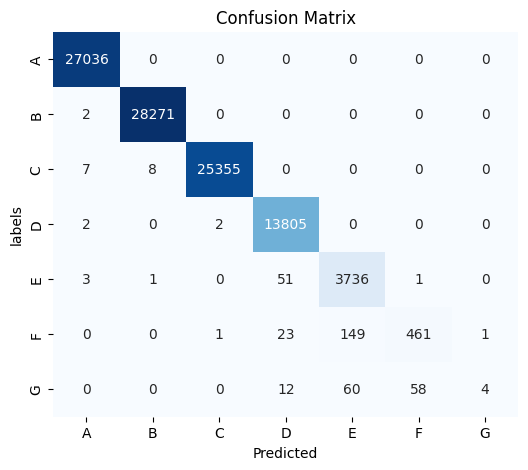

In [ ]:
# heatmap for confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("labels")
plt.show()

In [ ]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted A,Predicted B,Predicted C,Predicted D,Predicted E,Predicted F,Predicted G
Actual A,27036,0,0,0,0,0,0
Actual B,2,28271,0,0,0,0,0
Actual C,7,8,25355,0,0,0,0
Actual D,2,0,2,13805,0,0,0
Actual E,3,1,0,51,3736,1,0
Actual F,0,0,1,23,149,461,1
Actual G,0,0,0,12,60,58,4


Accuracy Score : 0.996153419014831
Classification Report
              precision    recall  f1-score   support

           A       1.00      1.00      1.00     27036
           B       1.00      1.00      1.00     28273
           C       1.00      1.00      1.00     25370
           D       0.99      1.00      1.00     13809
           E       0.95      0.99      0.97      3792
           F       0.89      0.73      0.80       635
           G       0.80      0.03      0.06       134

    accuracy                           1.00     99049
   macro avg       0.95      0.82      0.83     99049
weighted avg       1.00      1.00      1.00     99049



In [ ]:
# Save the model
import joblib

joblib.dump(rf_model, 'grade_model.pkl')


['grade_model.pkl']

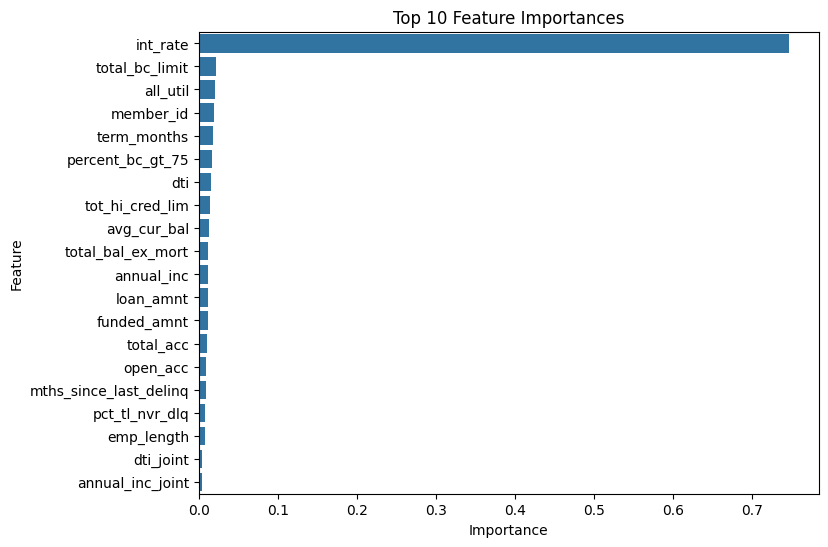

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

feat_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 10
plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(20))
plt.title('Top 10 Feature Importances')
plt.show()



Interest rate is disproportionally important in predicting loan letter.\
This is because there is a causal (vs. correlation) relationship between grade and interest rate - the grade (which is assigned first) determines the interest rate level. This means there is leakage, and we must correct for it.

Running two models: one to determine "risk level" via interest rate, and running the previous model with this new feature instead of interest rate.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import io
import pandas as pd
from pyspark.sql import SparkSession
from google.colab import drive
drive.mount('/content/drive')
#!ls '/content/drive/My Drive/Colab_Notebooks/Project4-Loan_Analysis'
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Create a Spark session
spark = SparkSession.builder.appName("GoogleDriveCSV2").getOrCreate()

# Define the file path
file_path = '/content/drive/MyDrive/Colab_Notebooks/Project4-Loan_Analysis/cleaned_loan_data_final.csv'

# Load the CSV file into a Spark DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True)

# convert the spark DataFrame into Panda
df_loans = df.toPandas()

df_loans.set_index('member_id', inplace=True)

# show the dataframe
df_loans.head()

Mounted at /content/drive


,pct_tl_nvr_dlq,delinq_amnt,grade,home_ownership,annual_inc,loan_amnt,emp_length,avg_cur_bal,pub_rec_bankruptcies,acc_now_delinq,...,mths_since_last_delinq,total_bal_ex_mort,verification_status,total_acc,total_bc_limit,chargeoff_within_12_mths,num_tl_90g_dpd_24m,delinq_2yrs,all_util,term_months
member_id,,,,,,,,,,,,,,,,,,,,,
1,100.0,0,C,RENT,55000.0,2500,10.0,1878.0,1,0,...,NaN,16901,Not Verified,34,36500,0,0,0,28.0,36
2,95.0,0,D,MORTGAGE,90000.0,30000,10.0,24763.0,1,0,...,71.0,99468,Verified,44,15000,0,0,0,57.0,60
3,100.0,0,D,MORTGAGE,59280.0,5000,6.0,18383.0,0,0,...,NaN,11749,Verified,13,13800,0,0,0,35.0,36
4,100.0,0,D,MORTGAGE,92000.0,4000,10.0,30505.0,0,0,...,NaN,36151,Verified,13,5000,0,0,0,70.0,36
5,92.3,0,C,MORTGAGE,57250.0,30000,10.0,9667.0,0,0,...,NaN,29674,Not Verified,26,9300,0,0,0,54.0,60


In [ ]:
df_loans['verification_status'].value_counts()

,count
verification_status,
Verified,295308
Not Verified,199934


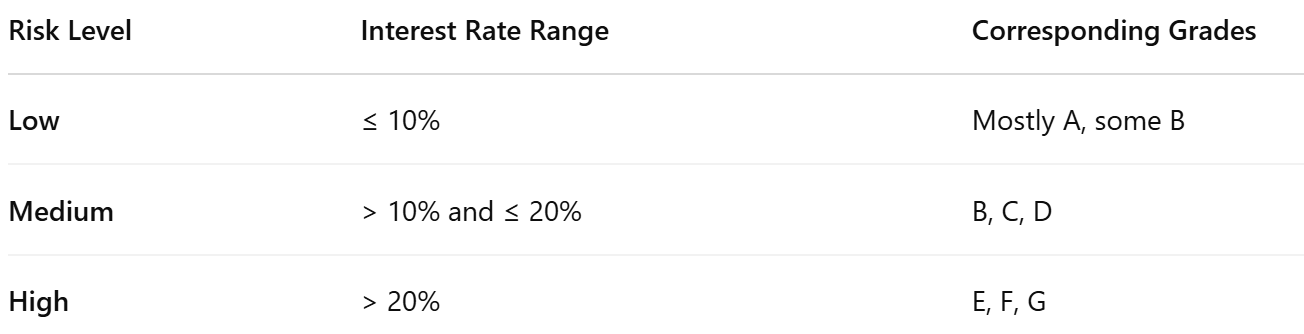

### Model 1

In [ ]:
#Define the feature set (exclude anything that leaks future info)
X = df_loans.drop(columns=['grade', 'int_rate'])

#Get the interest rate column (just for bucketing)
int_rate_col = df_loans['int_rate']

#Define the risk level based on interest rate
def bucket_risk(int_rate):
    if int_rate <= 16:
        return 'not_high'
    else:
        return 'high'

#Apply bucketing function
risk_levels = int_rate_col.apply(bucket_risk)

#Define this as your target for the risk classifier model
y = risk_levels
y.head(25)

,int_rate
member_id,
1,not_high
2,high
3,high
4,high
5,high
6,not_high
7,high
8,not_high
9,high


In [ ]:
# Encode the categorical variables using get_dummies
X = pd.get_dummies(X)

# Review the feature data
X.head()

,pct_tl_nvr_dlq,delinq_amnt,annual_inc,loan_amnt,emp_length,avg_cur_bal,pub_rec_bankruptcies,acc_now_delinq,open_acc,dti,...,num_tl_90g_dpd_24m,delinq_2yrs,all_util,term_months,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Verified
member_id,,,,,,,,,,,,,,,,,,,,,
1,100.0,0,55000.0,2500,10.0,1878.0,1,0,9,18.24,...,0,0,28.0,36,False,False,False,True,True,False
2,95.0,0,90000.0,30000,10.0,24763.0,1,0,13,26.52,...,0,0,57.0,60,False,True,False,False,False,True
3,100.0,0,59280.0,5000,6.0,18383.0,0,0,8,10.51,...,0,0,35.0,36,False,True,False,False,False,True
4,100.0,0,92000.0,4000,10.0,30505.0,0,0,10,16.74,...,0,0,70.0,36,False,True,False,False,False,True
5,92.3,0,57250.0,30000,10.0,9667.0,0,0,12,26.35,...,0,0,54.0,60,False,True,False,False,True,False


In [ ]:
# Separate the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# Create a random forest classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=78,
    class_weight='balanced'  # Adjusts weights automatically
)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [ ]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [ ]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Get unique labels from predictions and y_test to make it dynamic
labels = np.unique(np.concatenate((predictions, y_test)))

cm_df = pd.DataFrame(
    cm,
    index=["Actual " + str(label) for label in labels],
    columns=["Predicted " + str(label) for label in labels]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [ ]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted high,Predicted not_high
Actual high,7750,17454
Actual not_high,4270,69575


Accuracy Score : 0.7806742117537784
Classification Report
              precision    recall  f1-score   support

        high       0.64      0.31      0.42     25204
    not_high       0.80      0.94      0.86     73845

    accuracy                           0.78     99049
   macro avg       0.72      0.62      0.64     99049
weighted avg       0.76      0.78      0.75     99049



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

feat_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 10
plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(20))
plt.title('Top 10 Feature Importances')
plt.show()


NameError: name 'pd' is not defined

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:50:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy Score : 0.7885793899988894
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.92      0.87     73845
           1       0.64      0.39      0.48     25204

    accuracy                           0.79     99049
   macro avg       0.73      0.66      0.68     99049
weighted avg       0.77      0.79      0.77     99049



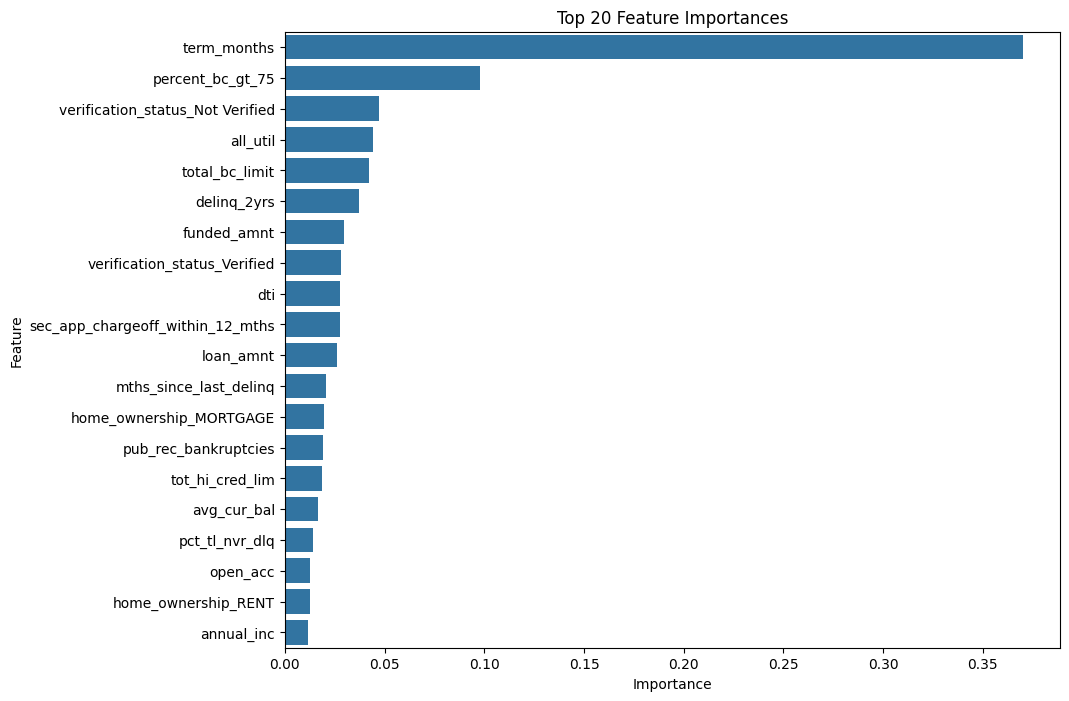

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

#Convert target to numeric if needed
y_encoded = y.map({'not_high': 0, 'high': 1})

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

# Standardize your features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and fit XGBoost model
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'  # For multiclass
)

xgb_model.fit(X_train_scaled, y_train)

# Predict
y_pred = xgb_model.predict(X_test_scaled)

# Evaluate
print("Accuracy Score :", accuracy_score(y_test, y_pred))
print("Classification Report")
print(classification_report(y_test, y_pred))


import matplotlib.pyplot as plt
import seaborn as sns

# Plot feature importance
importances = best_xgb.feature_importances_
features = X.columns

feat_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(20))
plt.title('Top 20 Feature Importances')
plt.show()



XGBoost performs better.

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [2, 3]  # Important for class imbalance
}

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
grid = GridSearchCV(xgb, param_grid, scoring='f1', cv=3, verbose=1)
grid.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:41:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:41:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:41:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:41:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:41:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 300],
                         'scale_pos_weight': [2, 3], 'subsample': [0.8, 1.0]},
             scoring='f1', verbose=1)

In [ ]:
# Using the results from hyperparam tuning exercise above....

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

#Re-train best model
best_xgb = XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=7,
    n_estimators=300,
    scale_pos_weight=2,
    subsample=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss')


best_xgb.fit(X_train_scaled, y_train)
y_pred = best_xgb.predict(X_test_scaled)

# Evaluate
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report\n", classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:48:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy Score: 0.7647023190542055
Classification Report
               precision    recall  f1-score   support

           0       0.87      0.81      0.84     73845
           1       0.53      0.63      0.58     25204

    accuracy                           0.76     99049
   macro avg       0.70      0.72      0.71     99049
weighted avg       0.78      0.76      0.77     99049



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:06:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy Score : 0.7883976617633697
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.91      0.87     73845
           1       0.63      0.42      0.50     25204

    accuracy                           0.79     99049
   macro avg       0.72      0.67      0.68     99049
weighted avg       0.77      0.79      0.77     99049



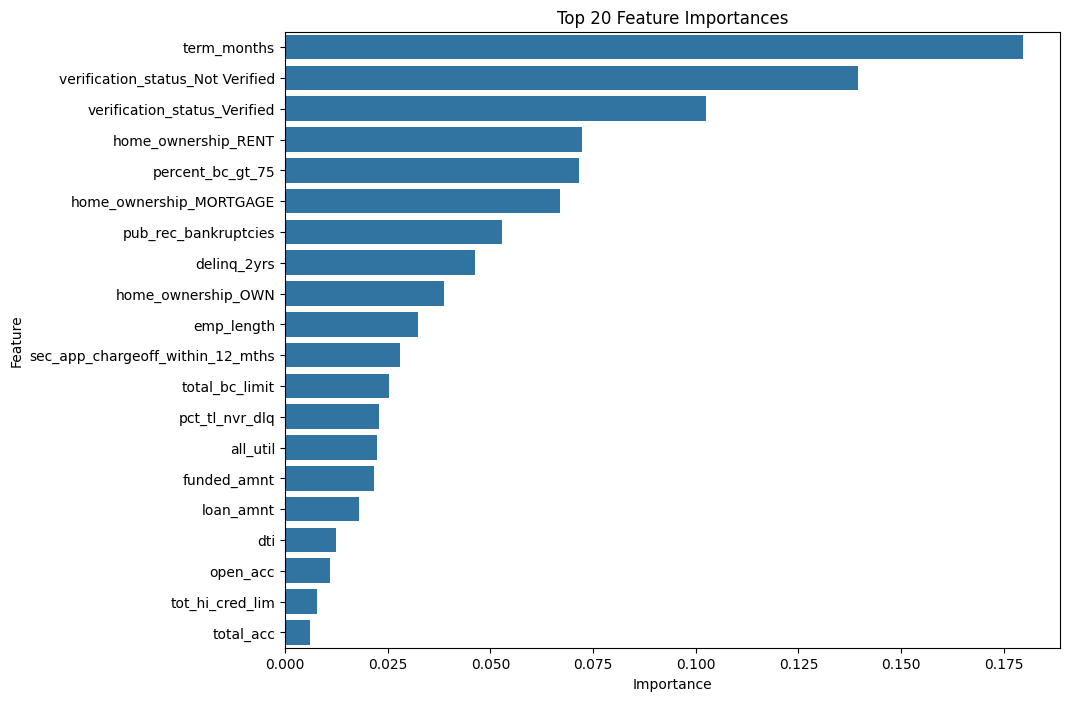

In [ ]:
#Let's try using SMOTE on or XGBoost model to see if we can improve the predictive power on high risk

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer # Import SimpleImputer

#Define the feature set (exclude anything that leaks future info)
X = df_loans.drop(columns=['grade', 'int_rate'])

X = pd.get_dummies(X)

#Get the interest rate column (just for bucketing)
int_rate_col = df_loans['int_rate']

#Define the risk level based on interest rate
def bucket_risk(int_rate):
    if int_rate <= 16:
        return 'not_high'
    else:
        return 'high'

#Apply bucketing function
risk_levels = int_rate_col.apply(bucket_risk)

#Define this as your target for the risk classifier model
y = risk_levels

# Convert target to numeric if needed
y_encoded = y.map({'not_high': 0, 'high': 1})

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

# Impute missing values before applying SMOTE
imputer = SimpleImputer(strategy='mean') # Create an imputer instance
X_train = imputer.fit_transform(X_train) # Fit and transform on training data
X_test = imputer.transform(X_test) # Transform testing data


# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Standardize features AFTER SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Create and fit XGBoost model
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'  # Binary classification
)

xgb_model.fit(X_train_scaled, y_train_res)

# Predict
y_pred = xgb_model.predict(X_test_scaled)

# Evaluate
print("Accuracy Score :", accuracy_score(y_test, y_pred))
print("Classification Report")
print(classification_report(y_test, y_pred))

# Plot feature importances
importances = xgb_model.feature_importances_
features = X.columns

feat_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(20))
plt.title('Top 20 Feature Importances')
plt.show()


##Let's now try Model 2 - using risk class instead of int_rate to predict the grade.

In [ ]:
# Define the feature set (exclude anything that leaks future info)
X = df_loans.drop(columns=['grade', 'int_rate'])

# X["risk_level"] = risk_levels

X = pd.get_dummies(X)

# Define this as your target for the risk classifier model
y = df_loans['grade']

# Encode the target variable `y` to numerical values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Fit and transform on the entire target data

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,  # Use the encoded target data for splitting
    test_size=0.2,
    stratify=y_encoded,  # Use the encoded target data for stratification
    random_state=42
)

# Impute missing values before applying SMOTE
from sklearn.impute import SimpleImputer #Make sure to import
imputer = SimpleImputer(strategy='mean') # Create an imputer instance
X_train = imputer.fit_transform(X_train) # Fit and transform on training data
X_test = imputer.transform(X_test) # Transform testing data

# Apply SMOTE to training data only
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Standardize features AFTER SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)  # Fit on resampled data
X_test_scaled = scaler.transform(X_test)

# Create and fit XGBoost model
from xgboost import XGBClassifier #Make sure to import
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train_scaled, y_train_res)  # Use resampled data for training

# Predict
y_pred = le.inverse_transform(xgb_model.predict(X_test_scaled))  # Inverse transform predictions

# Evaluate
print("Accuracy Score :", accuracy_score(le.inverse_transform(y_test), y_pred))  # Inverse transform y_test
print("Classification Report")
print(classification_report(le.inverse_transform(y_test), y_pred))  # Inverse transform y_test

# ... (your existing code for plotting feature importances) ...

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:15:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy Score : 0.4568042080182536
Classification Report
              precision    recall  f1-score   support

           A       0.63      0.68      0.65     27036
           B       0.41      0.45      0.43     28273
           C       0.39      0.47      0.43     25370
           D       0.41      0.15      0.22     13809
           E       0.22      0.05      0.08      3792
           F       0.06      0.16      0.08       635
           G       0.02      0.15      0.03       134

    accuracy                           0.46     99049
   macro avg       0.31      0.30      0.27     99049
weighted avg       0.46      0.46      0.44     99049

